In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import math
%matplotlib inline

In [2]:
train_X = pd.read_csv('train_X.csv').set_index('id')
train_y = pd.read_csv('train_y.csv').set_index('id')
validate_X = pd.read_csv('validate_X.csv').set_index('id')
validate_y = pd.read_csv('validate_y.csv').set_index('id')
X = pd.read_csv('train_X_full.csv').set_index('id')
y = pd.read_csv('train_y_full.csv').set_index('id')
test_X = pd.read_csv('test_X.csv').set_index('id')

**(2.5 балла)** Реализуйте градиентный спуск и протестируйте его для случая логистической регрессии на данных конкурса. Для сравнения качества разных подходов используйте значение оптимизируемого функционала.

В качестве критерия останова мы предлагаем использовать следующие условия:
 - евклидова норма разности текущего и нового векторов весов стала меньше, чем 1e-4
 - ограничение на число итераций (например, 10000)
 
Для начальной инициализации весов нужно сравнить следующие подходы:
 - нулевая начальная инициализация
 - случайная
 
Выполните следующие пункты и прокомментируйте полученные результаты:
- Рассмотрите как влияет размер шага на сходимость (попробуйте не менее 5-ти различных значений).
- Рассмотрите регуляризованную модель (не менее 5-ти различных коэффициентов регуляризации), которая описана выше, а также модель без регуляризатора. Сравните, влияет ли наличие регуляризации на скорость сходимости и качество (под качеством во всех случаях подразумевается значение исходного, нерегуляризованного функционала).
- Исследуйте качество оптимизируемого функционала в зависимости от номера итерации (при правильной реализации и подходящем размере шага он должен убывать).
- Влияет ли выбор начальной инициализации весов на скорость и качество?

В каждом пункте требуется построить необходимые графики скорости/качества и дать исчерпывающие выводы.

### Решение
Реализуем решение сразу классом, совместимым с sklearn

In [19]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import log_loss

# не работает при параллельном запуске
from scipy.special import expit

# def expit(x):
#     return 1 / (1 + np.exp(-x))

class MyClassifier(BaseEstimator, ClassifierMixin):
    loss_functions = {
        "log": (log_loss,),
    }

    def __init__(
            self,
            loss='log',
            penalty='l2',
            max_iter=10000,
            tol=1e-4,
            learning_rate='const',
            eta0=1,
            w=None,
            verbose=0,
            C=0,
            n_iter_no_change=1,
    ):
        self.loss = loss
        self.loss_func = loss
        self.penalty = penalty
        self.max_iter = max_iter
        self.tol = tol
        self.learning_rate = learning_rate
        self.eta0 = eta0
        self.verbose = verbose
        self.C = C
        self.n_iter_no_change = n_iter_no_change

        self.w = w
        self.iter = 0
        self.eta = 0
        self.iter_total = 0
        self.coef_ = None
        self.iter_error = []

    def get_loss_func(self):
        return MyClassifier.loss_functions[self.loss_func][0]

    def fit(self, _X, _y):
        X = np.array(_X)
        y = np.array(_y)

        if self.w is None:
            self.coef_ = np.zeros((X.shape[1], 1))
        else:
            self.coef_ = self.w.copy()

        # Добавляем ещё один признак который будет заменять регуляризатор b
        X = np.append(np.ones((X.shape[0], 1)), X, axis=1) * y

        # Сохраняем начальную инициализацию весов
        self.coef_ = np.append(np.zeros((1, 1)), self.coef_, axis=0)
        coef = self.coef_
        coef_norm = np.linalg.norm(coef)
        no_change = self.n_iter_no_change

        for i in range(self.max_iter):
            nu = self.get_learning_rate(i)
            if self.verbose > 1:
                self.iter_error.append([i, self.error_calc(X, y, coef)])
            coef = self.next_iter(coef, X, y, self.C, nu)
            coef_new_norm = np.linalg.norm(coef)
            if abs(coef_norm - coef_new_norm) < self.tol:
                if no_change == 1:
                    break
                else:
                    no_change -= 1
            else:
                no_change = self.n_iter_no_change
            
            self.coef_ = coef
            coef_norm = coef_new_norm

        self.iter_total = i
        self.error = self.error_calc(X, y, coef)

        if self.verbose:
            print('iter total:', self.iter_total)

        return self

    def get_learning_rate(self, n_iter):
        if self.learning_rate == 'const':
            return self.eta0

    def prob(self, X, w):
        prob = expit(X @ w)
        return np.hstack([1 - prob, prob])
    
    def error_calc(self, X, y, w):
        N = X.shape[0]
        return np.sum(np.log(1 + np.exp(-X @ w))) / N

    def loss_calc(self, X, y, w):
        prob = self.prob(X, w)
        return self.get_loss_func()(y, prob)

    def next_iter(self, w, X, y, C, nu):
        N = X.shape[0]
        gradient_matrix = X.T @ (1 - expit(X @ w)) / N
        w_new = w + gradient_matrix * nu - C * nu * w
        w_new[0] += C * nu * w[0]

        return w_new

    def predict_proba(self, _X):
        X = _X.copy()
        X = np.append(np.ones((X.shape[0], 1)), X, axis=1)
        prob = self.prob(X, self.coef_)
        return prob

Напишем функцию для проверки функционала классификатора по переданым параметрам

In [23]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import log_loss
columns = ['score', 'iter', 'time', 'error']
def createClf(Clf=MyClassifier, **args):
    clf = Clf(**args)
    res = cross_validate(clf, X, y, cv=5, scoring='neg_log_loss', return_estimator=True)
    iter_mean = np.mean([estimator.iter_total for estimator in res['estimator']])
    score_mean = -np.mean(res['test_score'])
    time_mean = np.mean(res['fit_time'])
    error_mean = np.mean([estimator.error for estimator in res['estimator']])
    return score_mean, iter_mean, time_mean, error_mean

Нулевая начальная инициализация

In [5]:
createClf(max_iter=10000, learning_rate='const', eta0=0.01)

(0.2422623528742171, 4756.0, 0.5568935871124268, 0.22056679527725181)

Случайная начальная инициализация

In [132]:
N, F = train_X.shape
res = []
for i in range(50):
    w = (np.random.random_sample((F, 1)) - 0.5) * 2
    result = createClf(max_iter=10000, verbose=0, learning_rate='const', eta0=0.3, w=w)
    res.append(result)

df_rand = pd.DataFrame(res, columns=columns)
df_rand.describe()

score         iter       time      error
count  50.000000    50.000000  50.000000  50.000000
mean    0.253533  1131.960000   0.119835   0.217443
std     0.001037   214.247296   0.025747   0.000609
min     0.251046   824.200000   0.078572   0.216190
25%     0.252715   945.100000   0.105385   0.217065
50%     0.253524  1080.500000   0.117049   0.217501
75%     0.254230  1278.350000   0.130577   0.217814
max     0.255878  1669.800000   0.197970   0.218803

Случайные веса в нашем случае дали небольшое улучшение разультат относительно нулевой инициализации

### Влияние размера шага на сходимость

In [54]:
res = []
for eta0 in np.arange(0.01, 1.6, 0.1):
    eta0 = math.floor(eta0 * 1000) / 1000
    qual = createClf(max_iter=10000, verbose=0, learning_rate='const', eta0=eta0)
    res.append([eta0] + list(qual))

df_step = pd.DataFrame(res, columns=['step'] + columns)
df_step.describe()

step      score         iter       time      error
count  16.000000  16.000000    16.000000  16.000000  16.000000
mean    0.760000   0.295029  6432.925000   0.629682   0.255019
std     0.476095   0.053756  3530.171027   0.348453   0.052326
min     0.010000   0.242262    34.800000   0.007354   0.212266
25%     0.385000   0.254935  4246.350000   0.419102   0.213366
50%     0.760000   0.263151  8005.200000   0.768626   0.227339
75%     1.135000   0.339362  9503.050000   0.899178   0.288517
max     1.510000   0.404552  9999.000000   1.023967   0.365365

In [56]:
df = df_step
fig = plt.subplot()
fig.scatter(list(df['error']), list(df['iter']))
for i, x in df.iterrows(): 
    fig.annotate(x['step'], (x['error'], x['iter']))

На наших данных получилось, что при шаге 0.11 мы сразу попадаем в локальный минимум и заканчиваем с минимальным количеством итераций.
Чем больше используется шаг, тем дольше функция осцилирует вокруг миниума, тем не менее позволяя достичь лучшего результата.
При совсем большом шаге, мы вылетаем в другую область миниума.

### Влияние регуляризации

In [81]:
res = []
for C in np.exp(np.arange(-12, 1, 3)):
    C = math.floor(C * 100000) / 100000
    qual = createClf(max_iter=10000, verbose=0, learning_rate='const', eta0=0.3, C=C)
    res.append([C] + list(qual))

df_reg = pd.DataFrame(res, columns=['step'] + columns)
df_reg.describe()

step     score         iter      time     error
count  5.000000  5.000000     5.000000  5.000000  5.000000
mean   0.210474  0.247961  3098.160000  0.303649  0.221866
std    0.441868  0.007144  3662.411029  0.324314  0.012849
min    0.000000  0.237202   282.800000  0.038146  0.212831
25%    0.000120  0.246072   413.800000  0.054471  0.213466
50%    0.002470  0.247665  1007.000000  0.136298  0.216474
75%    0.049780  0.253719  5260.000000  0.527305  0.222827
max    1.000000  0.255145  8527.200000  0.762025  0.243733

In [82]:
df = df_reg
fig = plt.subplot()
fig.scatter(list(df['error']), list(df['iter']))
for i, x in df.iterrows(): 
    fig.annotate(x['step'], (x['error'], x['iter']))

Регуляризатор сдерживает движение градиента, поэтому требуется меньше итераций для выхода из спуска. Данное преимущество так же и мешает, т.к. не достигается более точный минимум.

### Сходимость от номера итерации

In [87]:
clf = MyClassifier(max_iter=10000, verbose=2, learning_rate='const', eta0=0.3)
clf.fit(train_X, train_y)
df_iter = pd.DataFrame(clf.iter_error, columns=['iter', 'error'])

iter total: 6599


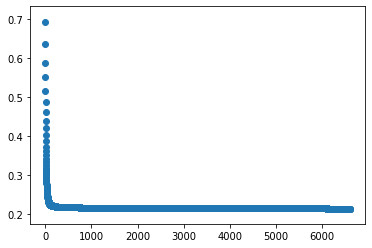

In [122]:
df = df_iter
plt.scatter(df['iter'], df['error'])

Как и следовало ожидать, в начале ошибка сильно убывает, а в конце уже практически не меняется

### Сходимость и ошибка от инициализации весов

В начале задачи провели эксперимент с различной начальной инициализацией весов.
На нашем конкретном датасете, начальная инициализация не дала, в среднем, улучшение модели.
Данное исследование необходимо проводить на каждом датасете, т.к. это позволит найти другие локальные минимумы.
Может случиться так, что запуск с нулевым весом не позволит выйти из локального минимума и найти глобальный минимум.

Метод градиентного спуска может быть весьма трудозатратен в случае большого размера обучающей выборки. Поэтому обычно используют метод стохастического градиентного спуска, где на каждой итерации выбирается случайный объект из обучающей выборки и обновление весов происходит сразу по этому объекту. 

**(1 балл)** Реализуйте метод стохастического градиентного спуска (sgd). В этом случае вы можете выбрать наиболее удачный функционал, исходя из предыдущего пункта (с регуляризацией, без), а также схему начальной инициализации весов. Реализуйте метод в виде класса, удовлетворяющего интерфейсу scikit-learn ([тут есть пример](http://danielhnyk.cz/creating-your-own-estimator-scikit-learn/)).

Сравните рассмотренные методы (градиентный спуск и sgd) между собой с точки зрения скорости сходимости и качества.

- Посмотрите как влияет размер шага на сходимость (попробуйте 4-5 различных значений)
- Исследуйте качество оптимизируемого функционала в зависимости от номера итерации

Выберите лучший размер шага и сравните качество и скорость сходимости реализованного метода и [его аналога из scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) (не забудьте выставить значения важных параметров tol и learning_rate для сравнения методов в приближённо равных условиях). Насколько получилось лучше/хуже, в чём могут быть причины?

В каждом пункте сделайте исчерпывающие выводы, подкреплённые графиками.

### Решение
Расширим базовый класс, переопределив способ пересчета весов

In [20]:
import random

from scipy.special import expit


class MyClassifierSGD(MyClassifier):
    def fit(self, X, y):
        random.seed(42)
        return super().fit(X, y)
        
    def next_iter(self, w, X, y, C, nu):
        N = X.shape[0]
        next_i = random.randrange(0, N)
        row = X[next_i:next_i + 1]
        gradient_matrix = row.T @ (1 - expit(row @ w))
        w_new = w + gradient_matrix * nu - C * nu * w
        w_new[0] += C * nu * w[0]

        return w_new

### Влияние шага на сходимость

In [36]:
res = []
for eta0 in np.geomspace(1e-5, 1e-2, num=10):
    qual = createClf(MyClassifierSGD, max_iter=10000, learning_rate='const', eta0=eta0, n_iter_no_change=5)
    res.append([eta0] + list(qual))

df_step = pd.DataFrame(res, columns=['step'] + columns)
df_step.describe()

step      score         iter       time      error
count  10.000000  10.000000    10.000000  10.000000  10.000000
mean    0.001865   0.489884  4727.060000   0.137198   0.480347
std     0.003209   0.208615  4856.165954   0.137809   0.219742
min     0.000010   0.250529     4.000000   0.004641   0.229373
25%     0.000060   0.276414    17.050000   0.006193   0.248469
50%     0.000340   0.532532  3608.400000   0.099304   0.530420
75%     0.001866   0.692845  9999.000000   0.274961   0.692842
max     0.010000   0.693149  9999.000000   0.322089   0.693144

In [37]:
df = df_step
plt.figure(figsize=(16, 8))
plt.scatter(list(df['step']), list(df['error']))
# plt.xscale('log')
plt.xlabel('eta')
plt.ylabel('error')
for i, x in df.iterrows(): 
    plt.annotate(x['iter'], (x['step'], x['error']))

Видим, что необходимо подбирать другой шаг, при больших шагах ошибка ещё больше. Так же необходимо ввести параметр n_iter_no_change, т.к. если мы не удачно выбрали строку для обучения, то алгоритм закончится

### Сходимость по итерациям

In [276]:
clf = MyClassifierSGD(max_iter=10000, verbose=2, learning_rate='const', eta0=0.004, tol=1e-6, n_iter_no_change=5)
clf.fit(train_X, train_y)
df_iter = pd.DataFrame(clf.iter_error, columns=['iter', 'error'])

iter total: 9999


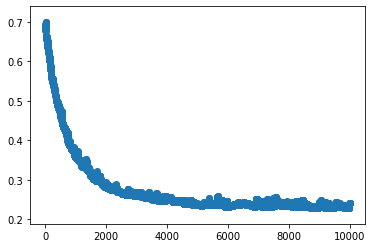

In [277]:
df = df_iter
plt.scatter(df['iter'], df['error'])

Видим, что из-за случайного выбора, не на каждой итерации у нас наблюдается уменьшение ошибки. Тем не менее, гораздо медленнее, но движемся в сторону оптимума

### Сравнение

In [50]:
from sklearn.linear_model import SGDClassifier
res = []
clf = MyClassifierSGD()
for eta0 in np.geomspace(1e-6, 1e-2, num=20):
    sgd = SGDClassifier(max_iter=10000, tol=1e-4, eta0=eta0, learning_rate='constant', loss='log', penalty='l2', n_iter_no_change=5, alpha=0)
    sgd.fit(train_X, np.array(train_y).ravel())
    error = clf.error_calc(train_X, train_y, sgd.coef_.T)[0]
    res.append([eta0, sgd.n_iter_, error])

df_step_sgd = pd.DataFrame(res, columns=['step', 'n_iter', 'error'])
df_step_sgd.describe()

step       n_iter      error
count  20.000000    20.000000  20.000000
mean    0.001301   304.600000   0.812864
std     0.002588   380.322218   0.061651
min     0.000001    12.000000   0.722152
25%     0.000010    28.000000   0.759423
50%     0.000103   121.000000   0.813186
75%     0.001024   433.750000   0.856164
max     0.010000  1266.000000   0.921550

Наш алгоритм оказался лучше встроенного.
Несколько отличается вычисление градиентного шага https://gitlab.uwe.ac.uk/ir-johnson/scikit-learn/-/blob/master/sklearn/linear_model/sgd_fast.pyx#L652
и формула функции потерь https://gitlab.uwe.ac.uk/ir-johnson/scikit-learn/-/blob/master/sklearn/linear_model/sgd_fast.pyx#L216
Считаю что за счет оптимизации скорости стандартного алгоритма, потеряли в качестве.
Однако, встроенный алгоритм дает гораздо более быструю сходимость